In [16]:
#importing necessary libraries
#from api.mapbox_api_driving import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
from pyproj import Geod

In [17]:
#reading in library branch and population demographics, both with geometry data
branchInfo = pd.read_csv('../library neighborhoods/completedWalkingNeighborhoodRadiiDF.csv')
#branchInfo = pd.read_csv('../library neighborhoods/5branchRadii.csv')
#branchInfo = pd.read_csv('../library neighborhoods/7minus5branchRadii.csv')
#branchInfo = pd.read_csv('../library neighborhoods/9minus7branchRadii.csv')
#branchInfo = pd.read_csv('../library neighborhoods/11minus9branchRadii.csv')
#branchInfo = pd.read_csv('../library neighborhoods/13minus11branchRadii.csv')
#branchInfo = pd.read_csv('../library neighborhoods/15minus13branchRadii.csv')
#branchInfo = pd.read_csv('../library neighborhoods/17minus15branchRadii.csv')
#branchInfo = pd.read_csv('../library neighborhoods/19minus17branchRadii.csv')
#branchInfo = pd.read_csv('../library neighborhoods/21minus19branchRadii.csv')
#branchInfo = pd.read_csv('../library neighborhoods/23minus21branchRadii.csv')
#branchInfo = pd.read_csv('../library neighborhoods/25minus23branchRadii.csv')
#branchInfo = pd.read_csv('../library neighborhoods/27minus25branchRadii.csv')
#branchInfo = pd.read_csv('../library neighborhoods/29minus27branchRadii.csv')

censusTracts = pd.read_csv('../data/clean/population_demographics.csv')

In [18]:
#removing unecessary columns from branchInfo
branchInfo = branchInfo.drop(columns = ['Unnamed: 0'])
#removing unecessary columns from censusTracts
censusTracts = censusTracts[['geoid','geometry','qualifying name']]

In [19]:
#converting censusTracts to a geodataframe (we could not load it as one since it already had a geometry column so we are simply
#converting the geometry column to a proper gpd geometry column).
censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    crs="epsg:4326",
    )

In [20]:
branchInfo[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchInfo['LOCATION']]
branchInfo.loc[:, 'LATITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LATITUDE'])
branchInfo.loc[:, 'LONGITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LONGITUDE'])

In [21]:
branchInfo = gpd.GeoDataFrame(
    branchInfo.loc[:, [c for c in branchInfo.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(branchInfo["geometry"]),
    crs="epsg:4326",
    )
branchInfo

,BRANCH,LOCATION,LATITUDE,LONGITUDE,geometry
0,Albany Park,"(41.97557881655979, -87.71361314512697)",41.975579,-87.713613,"MULTIPOLYGON (((-87.72184 41.99035, -87.72261 ..."
1,Altgeld,"(41.65719847558056, -87.59883829075173)",41.657198,-87.598838,"POLYGON ((-87.59456 41.66420, -87.59460 41.664..."
2,Archer Heights,"(41.80110836194246, -87.72648385568911)",41.801108,-87.726484,"MULTIPOLYGON (((-87.71500 41.80877, -87.71492 ..."
3,Austin,"(41.88917312206642, -87.7658203582574)",41.889173,-87.765820,"MULTIPOLYGON (((-87.75331 41.88441, -87.75306 ..."
4,Austin-Irving,"(41.95312267684315, -87.77928489355646)",41.953123,-87.779285,"POLYGON ((-87.78847 41.94793, -87.78971 41.947..."
...,...,...,...,...,...
76,West Pullman,"(41.67790647382097, -87.6431683153105)",41.677906,-87.643168,"MULTIPOLYGON (((-87.65235 41.68898, -87.65239 ..."
77,West Town,"(41.89594730478282, -87.66829305460979)",41.895947,-87.668293,"MULTIPOLYGON (((-87.66627 41.90779, -87.66602 ..."
78,"Whitney M. Young, Jr.","(41.7510184591363, -87.61495065361933)",41.751018,-87.614951,"POLYGON ((-87.59748 41.75102, -87.59806 41.750..."
79,Woodson Regional Library,"(41.720694885749005, -87.64304817213312)",41.720695,-87.643048,"MULTIPOLYGON (((-87.64675 41.72956, -87.64595 ..."


In [22]:

#helper method to ensure that two polygons overlap before getting the intersection. Gets the intersection then calculates
#the percent of overlapping area for a census tract and saves it to a dictionary with the census tract geo-id as the key and
#the percent as the value.
def check(polygon1, df, geoname, dictionary,key):
   
    for i in range(len(df)):
        if polygon1.intersects(df.loc[i,geoname]): 
            overlapPolygon = (polygon1.intersection(df.loc[i,geoname]))
            poly_area, poly_perimeter = geod.geometry_area_perimeter(overlapPolygon)
            overlapArea = poly_area*-1
            propOverlap = overlapArea / df.loc[i,'Area']
            #print(propOverlap)
            dictionary[df.loc[i, key]] = propOverlap
    return dictionary
   

In [23]:
#sets the crs of gpd types
def geoSetup(gdf):
    
    gdf = gdf.set_crs('EPSG:4326')
    

In [24]:
#cdf = gdf of geometry area which you want to get the coverage score
#idf = gdf of points for which you want to get an isochrone and dictionary of percent of overlap in cdf areas
#scoreString = a string that is the name of the coverage score column you choose
#dictString = a string that is the name of the dictionary column you choose
#cgs = a string that is the name of the geometry column in the cdf
#igs = a string that is the name of the geometry column in the idf
#lat = a string that is the name of the latitude column in the idf
#lon = a string that is the name of the longitude column in the idf
#key = a string that is the name of the column in the cdf that you want to represent the key of the dictionary

#def appendADS(cdf,idf,scoreString,dictString,cgs,igs,lat,lon,key):
def appendADS(cdf,idf,scoreString,dictString,cgs,igs,key):    
    #api = MapboxAPI()
    cdf[scoreString] = 0.0
    idf[dictString] = ''
    censusAreas = []
    global geod 
    geod = Geod(ellps='WGS84')
   
    geoSetup(cdf)
    geoSetup(idf)
   
    for index, row in cdf.iterrows():
        poly_area, poly_perimeter = geod.geometry_area_perimeter(row[cgs])
        poly_area = poly_area*-1
        censusAreas.append(poly_area)
    
    cdf['Area'] = censusAreas



    for i in range(len(idf)):
        dictionary = {}
        dictionary = check(idf.loc[i,igs],cdf,cgs, dictionary,key)
        branchInfo.loc[i,dictString]= [dictionary]
    
        for i in range(len(cdf)):
   
            if dictionary.get(cdf.loc[i, key]) != None:
                score = cdf.loc[i, scoreString]
                cdf.loc[i, scoreString] = score + dictionary.get(cdf.loc[i, key])
  
          

In [25]:
#appendADS(censusTracts,branchInfo, 'score', 'list of dict','geometry','geometry','LATITUDE','LONGITUDE','geoid')
appendADS(censusTracts,branchInfo, 'score', 'list of dict','geometry','geometry','geoid')

api = MapboxAPI()
censusTracts['score'] = 0.0
branchInfo['dictionary'] = ''
censusAreas = []
#geod = Geod(ellps='WGS84')
censusTracts = censusTracts.set_crs('EPSG:4326')
branchInfo = branchInfo.set_crs('EPSG:4326')
branchInfo[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchInfo['LOCATION']]
branchInfo.loc[:, 'LATITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LATITUDE'])
branchInfo.loc[:, 'LONGITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LONGITUDE'])


for index, row in censusTracts.iterrows():
    poly_area, poly_perimeter = geod.geometry_area_perimeter(row['geometry'])
    poly_area = poly_area*-1
    censusAreas.append(poly_area)
censusTracts['calculated area'] = censusAreas



for i in range(len(branchInfo)):
    dictionary = {}
    api_response =  api.get_data((branchInfo.loc[i,'LATITUDE'],branchInfo.loc[i,'LONGITUDE']), 5)
    branchInfo.loc[i,'geometry'] = shape(api_response)
    dictionary = check(branchInfo.loc[i,'geometry'],censusTracts,'geometry', dictionary)
    branchInfo.loc[i,'dictionary']= [dictionary]
    
    for i in range(len(censusTracts)):
   
        if dictionary.get(censusTracts.loc[i, 'geoid']) != None:
            score = censusTracts.loc[i, 'score']
            censusTracts.loc[i, 'score'] = score + dictionary.get(censusTracts.loc[i, 'geoid'])
  
          

Text(0.5, 1.0, 'Percent of Coverage')

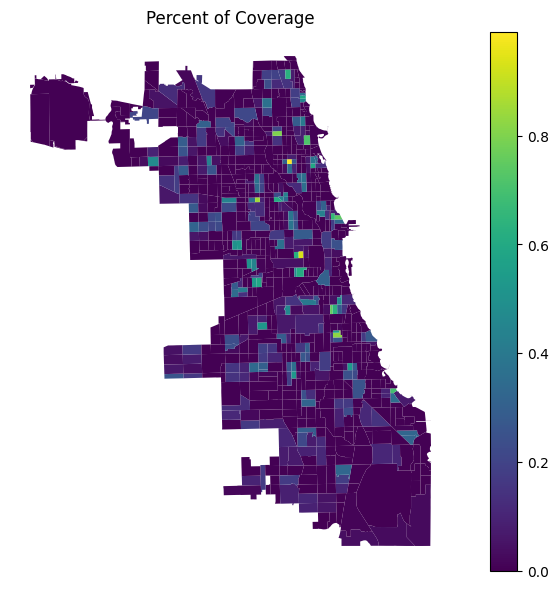

In [58]:
ax = censusTracts.plot(column = 'score', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Percent of Coverage")

In [25]:
censusTracts['score'].mean()

0.914186489508423

In [59]:
branchInfo.to_csv('../library neighborhoods/d5branchRadii.csv')